# Лабораторная работа
## Временные ряда. Основы. Модель AR

## Выполнил: __Щеткин Дмитрий Сергеевич__

группа 2.1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

In [2]:
df = pd.read_csv('data/tovar_moving.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df.head()

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


In [3]:
#1. Отложение последнего значения временного ряда
train = df.iloc[:-1].copy()
test_value = df.iloc[-1]
print("Отложенное значение:\n", test_value)

Отложенное значение:
 qty    423846.0
Name: 2013-12-02 00:00:00, dtype: float64


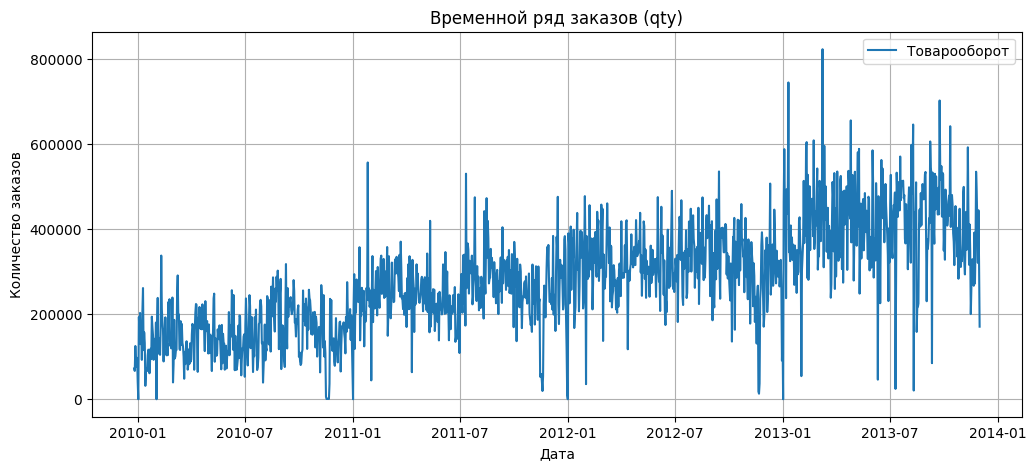

In [4]:
#2. Анализ временного ряда на тренд и сезонность
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['qty'], label='Товарооборот')
plt.title('Временной ряд заказов (qty)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid()
plt.legend()
plt.show()

Визуальный анализ:
- временной ряд имеет восходящий положительный тренд
- временной ряд имеет слабо выраженную сезонность

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.simplefilter("ignore", ValueWarning)

In [6]:
#3. Экспоненциальное сглаживание с α = 0.7
alpha = 0.7
model_exp = SimpleExpSmoothing(train['qty']).fit(smoothing_level=alpha, optimized=False)
forecast_exp = model_exp.forecast(1)

print("Прогноз по экспоненциальному сглаживанию:\n", forecast_exp.iloc[0])
print("Фактическое значение:\n", test_value['qty'])

Прогноз по экспоненциальному сглаживанию:
 225015.5226471296
Фактическое значение:
 423846.0


In [7]:
#4. Проверка на стационарность
def stat_test(df, max_diff=5, signif=0.05):
    current_df = df.copy()
    d = 0

    while d <= max_diff:
        test = adfuller(current_df)
        adf_stat = test[0]
        p_value = test[1]
        crit_values = test[4]

        print(f'adf: {adf_stat}')
        print(f'p-value: {p_value}')
        print(f'Critical values: {crit_values}')

        if adf_stat < crit_values['5%']:
            print(f'Ряд стационарен\n')
            return d
        else:
            print('Ряд не стационарен\n')
            current_df = current_df.diff().dropna()
            d += 1
    return None

order = stat_test(train['qty'])
print(f'Порядок интегрирования: {order}')

adf: -2.2553026410338006
p-value: 0.1867890312341643
Critical values: {'1%': np.float64(-3.434973278556316), '5%': np.float64(-2.8635818545830376), '10%': np.float64(-2.567857072940785)}
Ряд не стационарен

adf: -13.780727380503698
p-value: 9.307227521343053e-26
Critical values: {'1%': np.float64(-3.434973278556316), '5%': np.float64(-2.8635818545830376), '10%': np.float64(-2.567857072940785)}
Ряд стационарен

Порядок интегрирования: 1


<Figure size 1000x400 with 0 Axes>

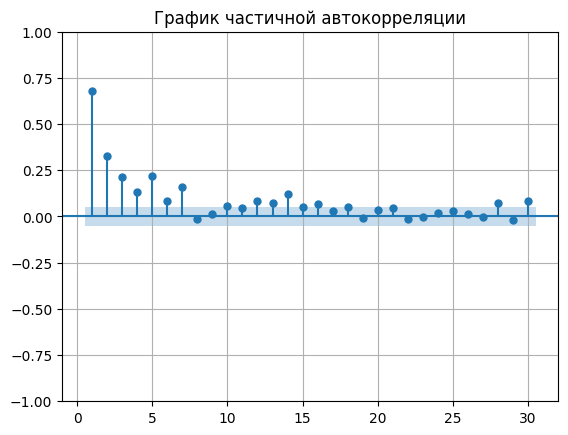

In [8]:
#5. Определение порядка AR по графику частичной автокорреляции
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 4))
plot_pacf(train['qty'].dropna(), lags=30, method='ywm', zero=False)
plt.title('График частичной автокорреляции')
plt.grid()
plt.show()

Визуальный анализ:
- Предполагаемый порядок AR модели: p = 2

In [9]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [10]:
#6. Построение AR-модели и предсказание последнего значения ряда
# По графику частичной автокорреляции был выбран порядок 2
ar_model = AutoReg(train['qty'], lags=2).fit()
forecast_ar = ar_model.predict(start=len(train), end=len(train))

print("Прогноз AR модели:", forecast_ar.iloc[0])

Прогноз AR модели: 244842.05394911143


In [11]:
#7. Сравнение моделей
print("Фактическое значение:", test_value['qty'])
print("Прогноз (экспоненциальное сглаживание):", forecast_exp.iloc[0])
print("Прогноз (AR-модель):", forecast_ar.iloc[0])

Фактическое значение: 423846.0
Прогноз (экспоненциальное сглаживание): 225015.5226471296
Прогноз (AR-модель): 244842.05394911143


Сравнение полученных результатов:
- Обе модели существенно занижают прогноз по сравнению с фактическим значением
- AR-модель (p=2) даёт немного лучший результат, чем экспоненциальное сглаживание
